In [1]:
# %pip install tensorflow-datasets

In [2]:
# import os

# def rename_images_in_folder(folder_path):
#     # Get all files in the folder
#     files = os.listdir(folder_path)

#     # Filter out non-image files if needed, based on file extension
#     image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
#     image_files = [f for f in files if any(f.lower().endswith(ext) for ext in image_extensions)]

#     # Rename files to 0.jpg, 1.jpg, 2.jpg, ..., but avoid overwriting
#     for idx, filename in enumerate(image_files):
#         old_file_path = os.path.join(folder_path, filename)
#         new_file_name = f"{idx}.jpg"
#         new_file_path = os.path.join(folder_path, new_file_name)
        
#         # Skip if the new file name already exists, increment index
#         while os.path.exists(new_file_path):
#             idx += 1
#             new_file_name = f"{idx}.jpg"
#             new_file_path = os.path.join(folder_path, new_file_name)

#         # Rename the file
#         os.rename(old_file_path, new_file_path)
#         print(f"Renamed {filename} to {new_file_name}")

# # Example usage
# folder_path = "./Data/VegetableImages/all_images"
# rename_images_in_folder(folder_path)


# Prerequirements

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import cv2
import glob
import imgaug.augmenters as iaa
import imgaug as ia
import datetime
import time

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Layer, LeakyReLU, Dropout, concatenate, Flatten, Dense, Add, UpSampling2D, Lambda, Activation, InputSpec, Concatenate)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from tensorboard.plugins.hparams import api as hp

import warnings
warnings.filterwarnings("ignore")

In [32]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

[]


In [33]:
def imshow(img: np.array):
    if img.shape[0] * 2 > img.shape[1]:
        fig = plt.figure(figsize=(7, 7))
    else:
        fig = plt.figure(figsize=(20, 20))
    plt.axis('off')
    plt.imshow(img)

# Preparing dataset

In [ ]:
ds = []
for idx, file in enumerate(glob.glob("./Data/VegetableImages/all_images/*")):
    ds.append(np.array(PIL.Image.open(file).resize((192,192))))
    # if idx >= 10001: break
ds = np.array(ds)
ds.shape

(1400, 112, 96, 3)

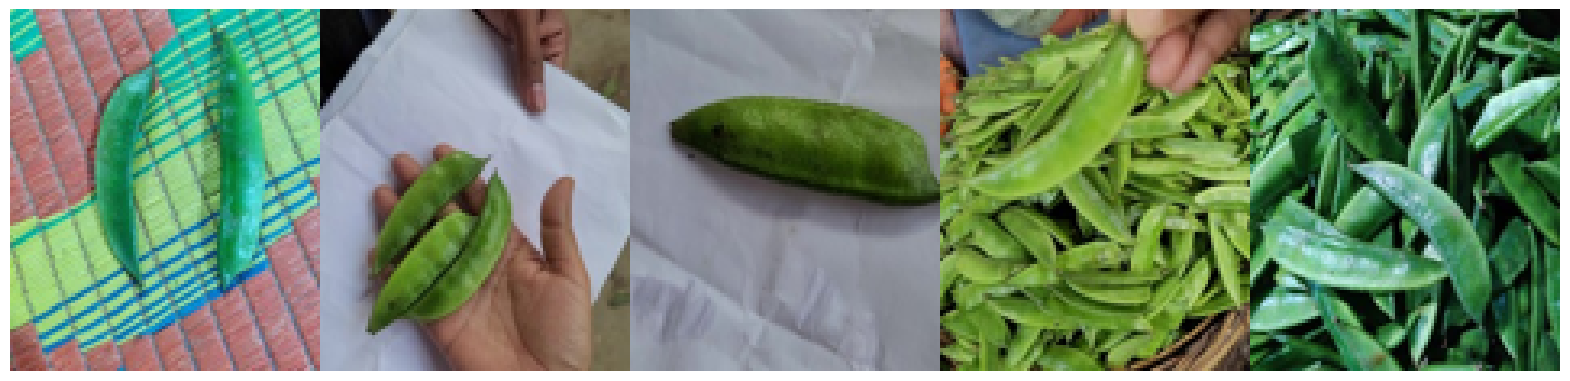

In [35]:
idxs = np.random.choice(len(ds), 5)
imshow(np.concatenate(ds[idxs], 1))

In [36]:
def create_line_mask(img):
    mask = np.full(img.shape, 255, np.uint8)
    for _ in range(np.random.randint(6, 10)):
        x1, x2 = np.random.randint(1, img.shape[1]), np.random.randint(1, img.shape[1])
        y1, y2 = np.random.randint(1, img.shape[0]), np.random.randint(1, img.shape[0])
        thickness = np.random.randint(4, 6)
        cv2.line(mask, (x1, y1), (x2, y2), (1, 1, 1), thickness)

    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

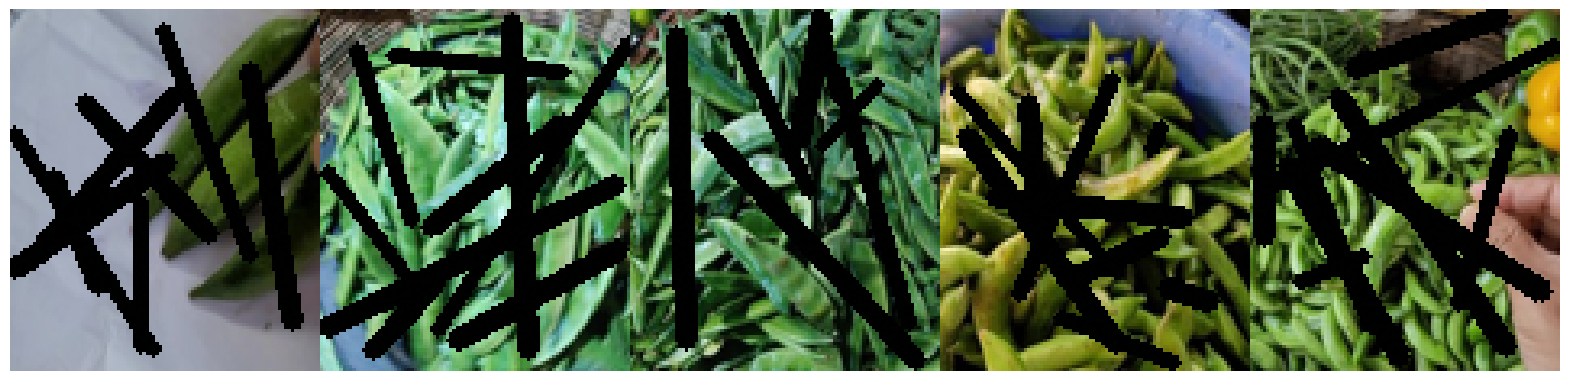

In [ ]:
idxs = np.random.choice(len(ds), 5)
masked = np.array(list(map(create_line_mask, ds[idxs])))
imshow(np.concatenate(masked, 1))

In [38]:
for idx, sample in enumerate(ds):
    PIL.Image.fromarray(sample).save(f'./Data/VegetableImages/all_images/{idx}.jpg')
    PIL.Image.fromarray(create_line_mask(sample)).save(f'./Data/VegetableImages/samples_line_masked/{idx}.jpg')
    # PIL.Image.fromarray(create_line_mask(sample)).save(f'./Data/VegetableImages/samples_square_masked/{idx}.jpg')

# Custom generator

In [39]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, X, Y, batch_size=64, dim=(192,192), n_channels=3): 
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels

        self.on_epoch_end()
        assert(len(self.X) == len(self.Y) or len(self.X) > 0)

        
    def __len__(self):
        return int(np.floor(len(self.X) / self.batch_size))


    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index+1) * self.batch_size]
        return self.__data_generation(indexes)

    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
    

    def __data_generation(self, idxs):
        X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels), dtype='float32')
        Y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels), dtype='float32')

        for i, idx in enumerate(idxs):
            image = np.array(PIL.Image.open(self.X[idx]))
            label = np.array(PIL.Image.open(self.Y[idx]))
            if np.random.randint(0, 100) < 20:
                X_batch[i,] = self.augment(image / 255)
                Y_batch[i,] = self.augment(label / 255)
            else:
                X_batch[i,] = image / 255
                Y_batch[i,] = label / 255

        return X_batch, Y_batch

    
    def augment(self, img):
        seq = iaa.Sequential([
            iaa.Sometimes(0.1, iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)))
        ])
        return seq(images=img)

In [40]:
def train_test_split(X, Y, train_size=0.8):   
    train_split = int(train_size * len(X))
    
    X_train = X[:train_split]
    Y_train = Y[:train_split]
    
    X_test = X[train_split:]
    Y_test = Y[train_split:]
    
    return X_train, X_test, Y_train, Y_test

In [41]:
X = sorted(glob.glob("./Data/VegetableImages/samples_line_masked/*.jpg"))
Y = sorted(glob.glob("./Data/VegetableImages/all_images/*.jpg"))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [42]:
train_gen = DataGenerator(X_train, Y_train)
test_gen = DataGenerator(X_test, Y_test)

In [43]:
print(np.array(PIL.Image.open(Y_train[4])).shape)


(112, 96, 3)


# Metrics

In [44]:
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection) / (K.sum(y_true + y_pred))

In [45]:
def jaccard_distance(y_true, y_pred, smooth=100):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [46]:
def cosine_similarity(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    return K.sum(y_pred * y_true) / tf.norm(y_pred) / tf.norm(y_true)

# Losses

In [47]:
MAE_loss = tf.keras.losses.MeanAbsoluteError()

In [48]:
def SSIM_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [49]:
def PSNR_loss(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

# Autoencoder

In [50]:
class Autoencoder(keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()


    def __ConvBlock(self, out, kernel_size, prev_layer):
        cnn = Conv2D(out, kernel_size, padding="same")(prev_layer)
        cnn = BatchNormalization()(cnn)
        cnn = LeakyReLU()(cnn)
        return cnn

    def __EncodeBlock(self, out, kernel_size, prev_layer, dr_rate=0.1):
        conv = self.__ConvBlock(out, kernel_size, prev_layer)
        conv = self.__ConvBlock(out, kernel_size, conv)
        conv = self.__ConvBlock(out, kernel_size, conv)
        conv = MaxPooling2D((2, 2))(conv)
        conv = Dropout(dr_rate)(conv)
        return conv


    def __DecodeBlock(self, out, kernel_size, prev_layer):
        up = Conv2DTranspose(out, kernel_size, strides=(2, 2), padding="same")(prev_layer)
        up = BatchNormalization()(up)
        up = LeakyReLU()(up)
        return up


    def model(self, input_shape=(192,192, 3), dr_rate=0.1, kernel_size=(3, 3)):
        inputs = keras.layers.Input(input_shape)

        conv1 = self.__EncodeBlock(32, kernel_size, inputs, dr_rate) 
        conv2 = self.__EncodeBlock(64, kernel_size, conv1, dr_rate)
        conv3 = self.__EncodeBlock(128, kernel_size, conv2, dr_rate) 
        conv4 = self.__EncodeBlock(256, kernel_size, conv3, dr_rate) 

        deconv1 = self.__DecodeBlock(256, kernel_size, conv4)
        deconv2 = self.__DecodeBlock(128, kernel_size, deconv1)
        deconv3 = self.__DecodeBlock(64, kernel_size, deconv2)
        deconv4 = self.__DecodeBlock(32, kernel_size, deconv3)

        outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(deconv4)

        return keras.models.Model(inputs=[inputs], outputs=[outputs])

## Parameters tuning on small part of dataset

In [51]:
HP_DROPOUT = hp.HParam("dropout", hp.Discrete([0.1, 0.2, 0.3, 0.4]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd', 'adagrad']))

METRIC = 'test_loss'

with tf.summary.create_file_writer('./tensorboard/autoencoder/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_DROPOUT, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC, display_name='test_loss')]
    )

In [52]:
def train_test_model(hparams):
    model = Autoencoder().model(input_shape=(192,192, 3), dr_rate=hparams[HP_DROPOUT])
    model.compile(
        optimizer=hparams[HP_OPTIMIZER],
        loss=SSIM_loss,
    )

    history = model.fit(
        train_gen, 
        validation_data = test_gen, 
        epochs=10, 
        steps_per_epoch = len(train_gen), 
        validation_steps = len(test_gen),
        # use_multiprocessing = True,
    )
    
    loss = model.evaluate(test_gen[0][0], test_gen[0][1])
    return loss

In [53]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)
        loss = train_test_model(hparams)
        tf.summary.scalar(METRIC, loss, step=1)

In [ ]:
session_num = 0

for dr_rate in HP_DROPOUT.domain.values:
    for optimizer in HP_OPTIMIZER.domain.values:
        hparams = {
            HP_DROPOUT: dr_rate,
            HP_OPTIMIZER: optimizer,
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning/' + run_name, hparams)
        session_num += 1

--- Starting trial: run-0
{'dropout': 0.1, 'optimizer': 'adagrad'}


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - loss: 0.8726 - val_loss: 0.7431
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - loss: 0.8592 - val_loss: 0.7429
Epoch 3/10
 9/17 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - loss: 0.8445

KeyboardInterrupt: 

## Model training

In [25]:
model = Autoencoder().model(input_shape=(192,192, 3), dr_rate=0.2)
model.compile(optimizer='adam', loss=SSIM_loss, metrics=[dice_coef, jaccard_distance, cosine_similarity])
keras.utils.plot_model(model, show_shapes=True, to_file='./autoencoder.png')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=20, 
    min_delta=0.005, 
    restore_best_weights=True
)

reduce = ReduceLROnPlateau(patience=5, monitor='val_loss', factor=0.5, min_delta=0.005)

In [26]:
log_dir = "./tensorboard/autoencoder/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [27]:
history = model.fit(
    train_gen, 
    validation_data = test_gen, 
    epochs=140, 
    steps_per_epoch = len(train_gen), 
    validation_steps = len(test_gen),
    use_multiprocessing = True,
    callbacks=[tensorboard_callback, early_stopping, reduce]
)

In [28]:
model.save("./models/autoencoder/")

# Autoencoder with skip-connections

In [29]:
class Autoencoder_skip(keras.Model):
    def __init__(self):
        super(Autoencoder_skip, self).__init__()


    def __ConvBlock(self, out, kernel_size, prev_layer):
        cnn = Conv2D(out, kernel_size, padding="same")(prev_layer)
        cnn = BatchNormalization()(cnn)
        cnn = LeakyReLU()(cnn)
        return cnn

    def __EncodeBlock(self, out, kernel_size, prev_layer, dr_rate=0.1):
        conv = self.__ConvBlock(out, kernel_size, prev_layer)
        conv = self.__ConvBlock(out, kernel_size, conv)
        conv = self.__ConvBlock(out, kernel_size, conv)
        conv = self.__ConvBlock(out, kernel_size, conv)
        pool = MaxPooling2D((2, 2))(conv)
        pool = Dropout(dr_rate)(pool)
        return conv, pool


    def __DecodeBlock(self, out, conv_out, kernel_size, prev_layer, skip_con):
        conv = self.__ConvBlock(conv_out, kernel_size, prev_layer)
        up = Conv2DTranspose(out, kernel_size, strides=(2, 2), padding="same")(conv)
        up = keras.layers.concatenate([up, skip_con], axis=3)
        up = BatchNormalization()(up)
        up = LeakyReLU()(up)
        return up


    def model(self, input_shape=(192,192, 3), dr_rate=0.1, kernel_size=(3, 3)):
        inputs = keras.layers.Input(input_shape)

        conv1, pool1 = self.__EncodeBlock(32, kernel_size, inputs, dr_rate)
        conv2, pool2 = self.__EncodeBlock(64, kernel_size, pool1, dr_rate)
        conv3, pool3 = self.__EncodeBlock(128, kernel_size, pool2, dr_rate)
        conv4, pool4 = self.__EncodeBlock(256, kernel_size, pool3, dr_rate) 

        deconv1 = self.__DecodeBlock(256, 512, kernel_size, pool4, conv4)
        deconv2 = self.__DecodeBlock(128, 256, kernel_size, deconv1, conv3)
        deconv3 = self.__DecodeBlock(64, 128, kernel_size, deconv2, conv2)
        deconv4 = self.__DecodeBlock(32, 64, kernel_size, deconv3, conv1)

        outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(deconv4)

        return keras.models.Model(inputs=[inputs], outputs=[outputs])

## Parameters tuning

In [30]:
HP_DROPOUT = hp.HParam("dropout", hp.Discrete([0.1, 0.2, 0.3, 0.4]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd', 'adagrad']))

METRIC = 'test_loss'

with tf.summary.create_file_writer('./tensorboard/autoencoder_skip/hparam_tuning/').as_default():
    hp.hparams_config(
        hparams=[HP_DROPOUT, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC, display_name='test_loss')]
    )

In [31]:
def train_test_model(hparams):
    model = Autoencoder_skip().model(input_shape=(192,192, 3), dr_rate=hparams[HP_DROPOUT])
    model.compile(
        optimizer=hparams[HP_OPTIMIZER],
        loss=SSIM_loss,
    )

    history = model.fit(
        train_gen, 
        validation_data = test_gen, 
        epochs=10, 
        steps_per_epoch = len(train_gen), 
        validation_steps = len(test_gen),
        use_multiprocessing = True,
    )
    
    loss = model.evaluate(test_gen[0][0], test_gen[0][1])
    return loss

In [32]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)
        loss = train_test_model(hparams)
        tf.summary.scalar(METRIC, loss, step=1)

In [33]:
session_num = 0

for dr_rate in HP_DROPOUT.domain.values:
    for optimizer in HP_OPTIMIZER.domain.values:
        hparams = {
            HP_DROPOUT: dr_rate,
            HP_OPTIMIZER: optimizer,
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning/' + run_name, hparams)
        session_num += 1

## Model training

In [7]:
model = Autoencoder_skip().model(input_shape=(192,192, 3), dr_rate=0.2)
model.compile(optimizer='adam', loss=SSIM_loss, metrics=[dice_coef, jaccard_distance, cosine_similarity])
keras.utils.plot_model(model, show_shapes=True, to_file='./autoencoder_skip.png')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=20, 
    min_delta=0.005, 
    restore_best_weights=True
)

reduce = ReduceLROnPlateau(patience=7, monitor='val_loss', factor=0.5, min_delta=0.005)

In [35]:
log_dir = "./tensorboard/autoencoder_skip/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [8]:
history = model.fit(
    train_gen, 
    validation_data = test_gen, 
    epochs=1800, 
    steps_per_epoch = len(train_gen), 
    validation_steps = len(test_gen),
    use_multiprocessing = True,
    callbacks=[tensorboard_callback, early_stopping, reduce]
)

In [10]:
model.save("./models/autoencoder_skip/")

# GAN

In [38]:
class Discriminator(keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()


    def __ConvBlock(self, out, kernel_size, dr_rate, prev_layer):
        cnn = Conv2D(out, kernel_size, padding="same")(prev_layer)
        cnn = BatchNormalization()(cnn)
        cnn = LeakyReLU()(cnn)
        cnn = Dropout(dr_rate)(cnn)
        return cnn


    def model(self, input_shape=(192,192, 3), dr_rate=0.1, kernel_size=(3, 3)):
        inputs = keras.layers.Input(input_shape)

        conv2 = self.__ConvBlock(16, kernel_size, dr_rate, inputs)
        conv3 = self.__ConvBlock(32, kernel_size, dr_rate, conv2)
        conv4 = self.__ConvBlock(64, kernel_size, dr_rate, conv3)
        conv5 = self.__ConvBlock(128, kernel_size, dr_rate, conv4)
        conv6 = self.__ConvBlock(256, kernel_size, dr_rate, conv5)

        outputs = Flatten()(conv6)
        outputs = Dense(1, activation = 'sigmoid')(outputs)

        return keras.models.Model(inputs=[inputs], outputs=[outputs])

In [39]:
generator = Autoencoder_skip().model(input_shape=(192,192, 3), dr_rate=0.2)
discriminator = Discriminator().model(input_shape=(192,192, 3), dr_rate=0.4)

keras.utils.plot_model(generator, show_shapes=True, to_file='./generator.png')
keras.utils.plot_model(discriminator, show_shapes=True, to_file='./discriminator.png')

In [41]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=False)

def generator_loss(y_real, y_gen, fake_output):
    l1_loss = tf.reduce_mean(tf.abs(y_gen - y_real))
    gan_loss = cross_entropy(tf.ones_like(fake_output, dtype= 'float32'), fake_output)
    return l1_loss + 3 * gan_loss


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output, dtype= 'float32') * np.random.uniform(low = 0.9, high = 1), real_output)
    gen_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    return 0.5 * (real_loss + gen_loss)


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [40]:
EPOCHS = 4000

discr_loss = tf.keras.metrics.Mean(name='dicriminator_loss')
gene_loss = tf.keras.metrics.Mean(name='generator_loss')
cosine = tf.keras.metrics.Mean(name='cosine_sim')

@tf.function
def train_step(X, Y):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(X, training=True)

        real_output = discriminator(Y, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(Y, generated_images, fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    gene_loss(gen_loss)
    discr_loss(disc_loss)
    cosine(K.mean(cosine_similarity(Y, generated_images)))

    
def train(train_gen, test_gen, epochs):
    for epoch in range(epochs):
        start = time.time()
        for X, Y in train_gen:
            train_step(X, Y)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print ('Generator loss {}, Discriminator loss {} \n'.format(gene_loss.result(), discr_loss.result()))
        
        ## validation
        val_generated_images = generator(test_gen[0][0], training=False)
        val_fake_output = discriminator(val_generated_images, training=False)
        val_gen_loss = generator_loss(test_gen[0][1], val_generated_images, val_fake_output)
        
        with summary_writer.as_default():
            tf.summary.scalar('generator_loss', gene_loss.result(), step=epoch)
            tf.summary.scalar('discriminator_loss', discr_loss.result(), step=epoch)
            tf.summary.scalar('cosine_similarity',cosine.result(), step=epoch)
            tf.summary.scalar('val_generator_loss',val_gen_loss, step=epoch)
            
        discr_loss.reset_states()
        gene_loss.reset_states()
        cosine.reset_states()

In [42]:
log_dir = "./tensorboard/gan/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
tensorboard_callback.set_model(generator)
summary_writer = tf.summary.create_file_writer(log_dir)

In [43]:
train(train_gen, test_gen, EPOCHS)

In [44]:
generator.save('./models/gan/generator/')
discriminator.save('./models/gan/discriminator/')

# Partial convolution

## Changed generator, which creates masks online

In [45]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, Y, batch_size=64, dim=(192,192), n_channels=3): 
        self.Y = Y
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels

        self.on_epoch_end()

        
    def __len__(self):
        return int(np.floor(len(self.Y) / self.batch_size))


    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index+1) * self.batch_size]
        return self.__data_generation(indexes)

    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.Y))
    

    def __data_generation(self, idxs):
        images_masked_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels), dtype='float32')
        masks_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels), dtype='float32')
        Y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels), dtype='float32')

        for i, idx in enumerate(idxs):
            label = np.array(PIL.Image.open(self.Y[idx]))
            images_masked, masks = self.create_line_mask(label)
            
            Y_batch[i,] = label / 255
            images_masked_batch[i,] = images_masked / 255
            masks_batch[i,] = masks / 255

        return [images_masked_batch, masks_batch], Y_batch

    
    def create_line_mask(self, img):
        mask = np.full(img.shape, 255, np.uint8)
        for _ in range(np.random.randint(6, 10)):
            x1, x2 = np.random.randint(1, img.shape[1]), np.random.randint(1, img.shape[1])
            y1, y2 = np.random.randint(1, img.shape[0]), np.random.randint(1, img.shape[0])
            thickness = np.random.randint(4, 6)
            cv2.line(mask, (x1, y1), (x2, y2), (0, 0, 0), thickness)

        image_masked = img.copy()
        image_masked[mask==0] = 255
        return image_masked, mask

In [46]:
Y = sorted(glob.glob("/kaggle/input/cv-project3/data/samples/*.png"))[:500]
train_gen = DataGenerator(Y)

## Partial convolution layer

In [47]:
## Reference: https://github.com/ayulockin/deepimageinpainting/blob/master/utils/pconv_layer.py

class PConv2D(Conv2D):
    def __init__(self, *args, n_channels=3, mono=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_spec = [InputSpec(ndim=4), InputSpec(ndim=4)]

        
    def build(self, input_shape):        
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
            
        if input_shape[0][channel_axis] is None:
            raise ValueError('The channel dimension of the inputs should be defined. Found `None`.')
            
        self.input_dim = input_shape[0][channel_axis]
        
        kernel_shape = self.kernel_size + (self.input_dim, self.filters)
        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='img_kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.kernel_mask = K.ones(shape=self.kernel_size + (self.input_dim, self.filters))

        self.pconv_padding = (
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)), 
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)), 
        )

        self.window_size = self.kernel_size[0] * self.kernel_size[1]
        
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.built = True

        
    def call(self, inputs, mask=None):
        if type(inputs) is not list or len(inputs) != 2:
            raise Exception('PartialConvolution2D must be called on a list of two tensors [img, mask]. Instead got: ' + str(inputs))

        images = K.spatial_2d_padding(inputs[0], self.pconv_padding, self.data_format)
        masks = K.spatial_2d_padding(inputs[1], self.pconv_padding, self.data_format)

        mask_output = K.conv2d(
            masks, self.kernel_mask, 
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )

        img_output = K.conv2d(
            (images*masks), self.kernel, 
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )        

        mask_ratio = self.window_size / (mask_output + 1e-8)

        mask_output = K.clip(mask_output, 0, 1)

        mask_ratio = mask_ratio * mask_output

        img_output = img_output * mask_ratio

        if self.use_bias:
            img_output = K.bias_add(
                img_output,
                self.bias,
                data_format=self.data_format)
        
        if self.activation is not None:
            img_output = self.activation(img_output)
            
        return [img_output, mask_output]
    
    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[0][1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0][0],) + tuple(new_space) + (self.filters,)
            return [new_shape, new_shape]
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0], self.filters) + tuple(new_space)
            return [new_shape, new_shape]

def conv_output_length(input_length, filter_size,
                       padding, stride, dilation=1):
    if input_length is None:
        return None
    assert padding in {'same', 'valid', 'full', 'causal'}
    dilated_filter_size = (filter_size - 1) * dilation + 1
    if padding == 'same':
        output_length = input_length
    elif padding == 'valid':
        output_length = input_length - dilated_filter_size + 1
    elif padding == 'causal':
        output_length = input_length
    elif padding == 'full':
        output_length = input_length + dilated_filter_size - 1
    return (output_length + stride - 1) // stride

In [48]:
class PartialConvolutionInpainting(keras.Model):
    def __init__(self):
        super(PartialConvolutionInpainting, self).__init__()


    def __PConvBlock(self, out, kernel_size, strides, layer, mask):
        pconv, mask = PConv2D(out, kernel_size, strides=strides, padding='same')([layer, mask])
#         pconv = BatchNormalization()(pconv)
        pconv = LeakyReLU()(pconv)
        return pconv, mask

    
    def __EncodeBlock(self, out, kernel_size, layer, mask):
        pconv1, mask1 = self.__PConvBlock(out, kernel_size, 1, layer, mask)
        pconv2, mask2 = self.__PConvBlock(out, kernel_size, 2, pconv1, mask1)
        return pconv1, mask1, pconv2, mask2
    
    
    def __DecodeBlock(self, out, out2, kernel_size, layer, mask, skip_layer, skip_mask):
        up_img = UpSampling2D(size=(2,2))(layer)
        up_mask = UpSampling2D(size=(2,2))(mask)
        concat_img = Concatenate(axis=3)([skip_layer, up_img])
        concat_mask = Concatenate(axis=3)([skip_mask, up_mask])
        pconv1, mask1 = self.__PConvBlock(out, kernel_size, 1, concat_img, concat_mask)
        pconv2, mask2 = self.__PConvBlock(out2, kernel_size, 1, pconv1, mask1)
        return pconv2, mask2
    
    
    def model(self, input_shape=(192,192, 3), kernel_size=(3, 3)):
        input_image = Input(input_shape)
        input_mask = Input(input_shape)
        
        pconv1, mask1, pconv2, mask2 = self.__EncodeBlock(32, kernel_size, input_image, input_mask)
        pconv3, mask3, pconv4, mask4 = self.__EncodeBlock(64, kernel_size, pconv2, mask2)
        pconv5, mask5, pconv6, mask6 = self.__EncodeBlock(128, kernel_size, pconv4, mask4)
        pconv7, mask7, pconv8, mask8 = self.__EncodeBlock(256, kernel_size, pconv6, mask6)
        
        pconv9, mask9 = self.__DecodeBlock(256, 128, kernel_size, pconv8, mask8, pconv7, mask7)
        pconv10, mask10 = self.__DecodeBlock(128, 64, kernel_size, pconv9, mask9, pconv5, mask5)
        pconv11, mask11 = self.__DecodeBlock(64, 32, kernel_size, pconv10, mask10, pconv3, mask3)
        pconv12, mask12 = self.__DecodeBlock(32, 3, kernel_size, pconv11, mask11, pconv1, mask1)
        
        outputs = Conv2D(3, kernel_size, activation='sigmoid', padding='same')(pconv12)
        
        return keras.models.Model(inputs=[input_image, input_mask], outputs=[outputs])

In [49]:
model = PartialConvolutionInpainting().model()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef, cosine_similarity])
keras.utils.plot_model(model, show_shapes=True, to_file='./pconv_model.png')

In [50]:
log_dir = "./tensorboard/pconv/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [51]:
history = model.fit(
    train_gen, 
    epochs=500, 
    steps_per_epoch = len(train_gen), 
    use_multiprocessing = True,
    callbacks=[tensorboard_callback]
)

In [52]:
model.save('./models/pconv/')